# Visualising Recognised & Unrecognised Doodles


In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import ast
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from IPython.core.display import HTML
start = dt.datetime.now()

In [2]:
DP_DIR = '../input/shuffle-animal-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'
# INPUT_DIR = '../input/'
BW_DIR = '../input/black-white-cnn-animals/'
GS_DIR = '../input/greyscale-mobilenet-animals/'
BASE_SIZE = 256
NCSVS = 100
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

class Simplified():
    def __init__(self, input_path='./input'):
        self.input_path = input_path

    def list_all_categories(self):
        files = os.listdir(os.path.join(self.input_path, 'train_simplified'))
        return [f2cat(f) for f in files]

    def read_training_csv(self, category, nrows=None, usecols=None, drawing_transform=False):
        df = pd.read_csv(os.path.join(self.input_path, 'train_simplified', category + '.csv'),
                         nrows=nrows, parse_dates=['timestamp'], usecols=usecols)
        if drawing_transform:
            df['drawing'] = df['drawing'].apply(ast.literal_eval)
        return df

In [3]:
s = Simplified(INPUT_DIR)
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow',
           'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish',
           'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda',
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion',
           'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel',
           'swan', 'teddy-bear', 'tiger', 'whale', 'zebra']
NCATS = len(animals)

In [6]:
df = s.read_training_csv('frog', nrows=100, drawing_transform=True)
df.head()

drawing = df.drawing.values[0]
print(drawing)
print('--------------------------------------')
print('This drawing has {} strokes.'.format(len(drawing)))
print('i, [[xs], [ys]]')
for i, stroke in enumerate(drawing):
    print(i, stroke)

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[26, 35, 55, 68, 98, 117, 170, 190, 204, 218...",5835124874674176,True,2017-03-14 12:50:13.036730,frog
1,US,"[[[121, 139, 150, 163, 166, 177, 194, 218, 237...",6036653950894080,True,2017-03-09 16:47:29.913470,frog
2,GB,"[[[33, 24, 18, 0, 5, 22], [61, 61, 64, 81, 88,...",4684123488649216,True,2017-01-24 12:37:28.631540,frog
3,US,"[[[77, 77, 84, 112, 126, 137, 137, 145, 149, 1...",5127312334913536,False,2017-03-13 02:17:31.220670,frog
4,MX,"[[[44, 33, 27, 27, 30, 48, 64, 70, 82, 83, 79,...",5535762349031424,True,2017-03-02 05:34:59.688230,frog


[[[26, 35, 55, 68, 98, 117, 170, 190, 204, 218, 244, 255, 255, 252, 243, 224, 208, 187, 159, 134, 115, 93, 75, 54, 33], [32, 13, 0, 2, 17, 23, 8, 6, 8, 16, 46, 71, 98, 123, 142, 166, 180, 191, 196, 192, 185, 170, 152, 116, 43]], [[77, 64, 62, 67, 80, 84, 89, 88, 83], [22, 32, 51, 60, 65, 63, 56, 49, 44]], [[204, 194, 183, 180, 182, 187, 196, 217, 222, 223, 218, 207, 194, 161], [37, 37, 46, 57, 66, 71, 74, 67, 60, 51, 47, 46, 50, 71]], [[208, 208], [55, 55]], [[61, 61], [35, 35]], [[102, 120, 144, 165, 215], [147, 162, 165, 158, 128]], [[61, 61], [9, 9]], [[47, 36, 25, 9, 0, 3, 10, 27, 46, 55, 62, 61, 68, 74, 82, 89, 95, 128], [95, 99, 113, 154, 218, 232, 239, 245, 243, 234, 213, 220, 220, 225, 223, 231, 227, 155]]]
--------------------------------------
This drawing has 8 strokes.
i, [[xs], [ys]]
0 [[26, 35, 55, 68, 98, 117, 170, 190, 204, 218, 244, 255, 255, 252, 243, 224, 208, 187, 159, 134, 115, 93, 75, 54, 33], [32, 13, 0, 2, 17, 23, 8, 6, 8, 16, 46, 71, 98, 123, 142, 166, 180, 191

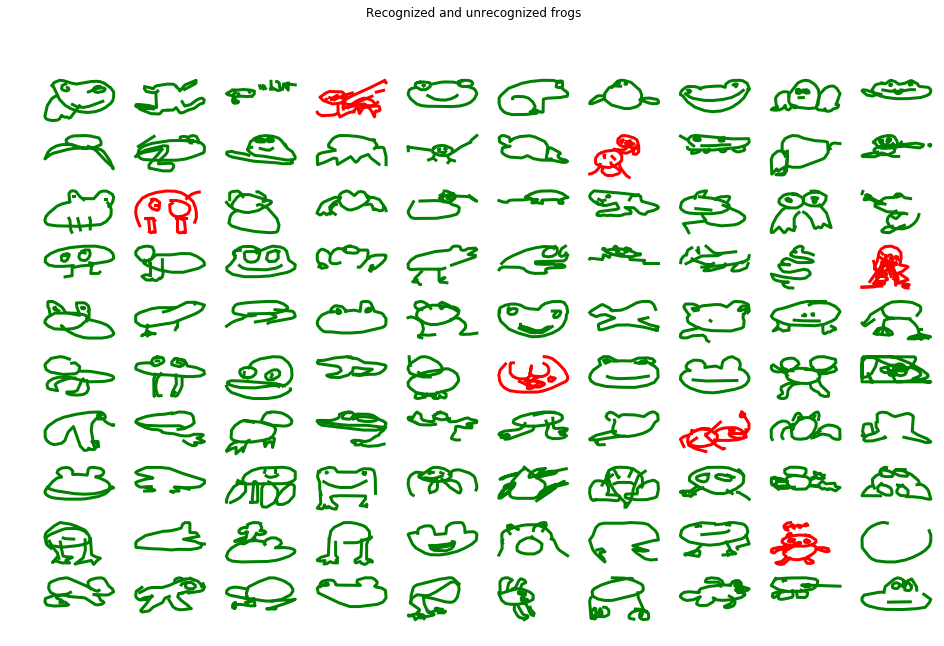

In [8]:
n = 10
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(16, 10))
for i, row in df[: n * n].iterrows():
    ax = axs[i // n, i % n]
    for x, y in row.drawing:
        color = 'green' if row.recognized else 'red'
        ax.plot(x, -np.array(y), lw=3, color=color)
    ax.axis('off')
plt.suptitle('Recognized and unrecognized frogs')
plt.show();

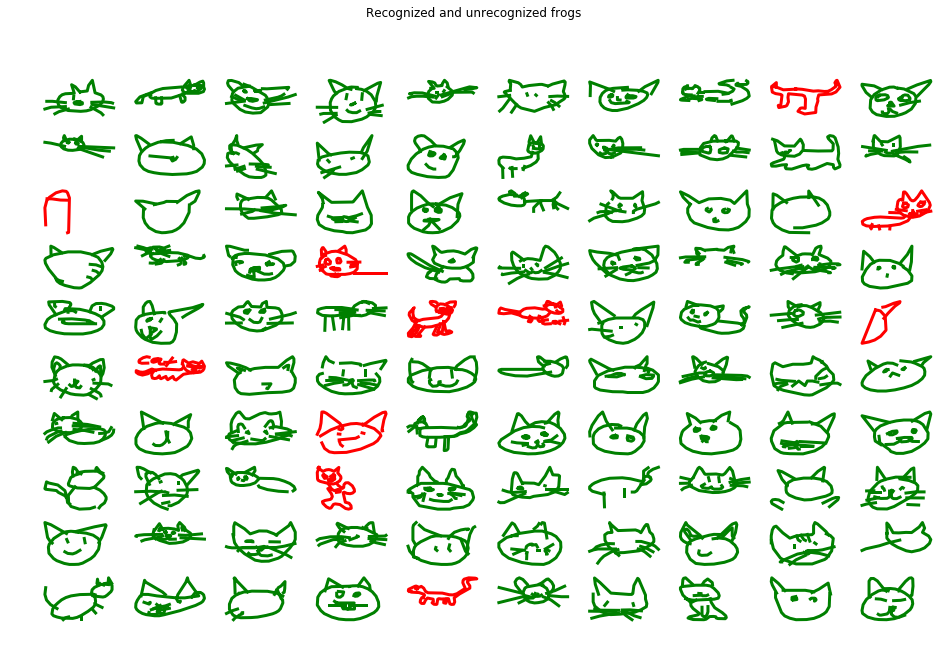

In [9]:
df = s.read_training_csv('cat', nrows=100, drawing_transform=True)
n = 10
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(16, 10))
for i, row in df[: n * n].iterrows():
    ax = axs[i // n, i % n]
    for x, y in row.drawing:
        color = 'green' if row.recognized else 'red'
        ax.plot(x, -np.array(y), lw=3, color=color)
    ax.axis('off')
plt.suptitle('Recognized and unrecognized frogs')
plt.show();